# EDA for PetFinder6000

##### Last updated as of: 23 May 2023, 17:00:00

## 1. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import os
import glob
import shutil
import boto3
import sagemaker

## 2. Load Data

In [3]:
%env AWS_PROFILE=aeroxye-sagemaker

env: AWS_PROFILE=aeroxye-sagemaker


In [5]:
!aws sts get-caller-identity

{
    "UserId": "AROAWC4YSIQL5OBFCNGEX:botocore-session-1686723394",
    "Account": "418542404631",
    "Arn": "arn:aws:sts::418542404631:assumed-role/SageMaker-UserRole/botocore-session-1686723394"
}
{
    "UserId": "AROAWC4YSIQL5OBFCNGEX:botocore-session-1686723394",
    "Account": "418542404631",
    "Arn": "arn:aws:sts::418542404631:assumed-role/SageMaker-UserRole/botocore-session-1686723394"
}


In [6]:
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='SageMaker-UserRole')['Role']['Arn']
region = boto3.Session().region_name

Couldn't call 'get_role' to get Role ARN from role name SageMaker-UserRole to get Role path.


In [7]:
def get_data_from_s3(local_path, data_bucket, object_prefix):
    if not os.path.exists(local_path):
        os.makedirs(local_path)
    else:
        shutil.rmtree(local_path)
        os.makedirs(local_path)

    pattern = r'[0-9]+'
    s3 = boto3.client("s3")

    result = s3.list_objects(Bucket=data_bucket, Prefix=object_prefix, Delimiter="/")
    subfolders = [re.search(pattern, o.get("Prefix")).group() for o in result.get("CommonPrefixes")]
    subfolders.sort(reverse=True)

    object_path = object_prefix + subfolders[0] + "/"
    files = s3.list_objects(Bucket=data_bucket, Prefix=object_path, Delimiter="/")

    pattern = rf'{object_path}(.+)'
    for content in files.get("Contents"):
        file_path = content.get("Key")
        filename = re.findall(pattern, file_path)[0]
        print(filename)

        with open(local_path+filename, 'wb') as file:
            s3.download_fileobj(
                Bucket=data_bucket,
                Key=file_path,
                Fileobj=file
            )

    file_list = glob.glob(local_path + "*")
    print(file_list)

    dfs = [] # an empty list to store the data frames
    for file in file_list:
        try:
            data = pd.read_csv(file) # read data frame from csv file
        except:
            data = pd.read_json(file, lines=True) # read data frame from json file
        dfs.append(data) # append the data frame to the list

    return pd.concat(dfs, ignore_index=True)

In [8]:
data_bucket = "dynamodbpetfinder"

users = get_data_from_s3(local_path="./data/user/", data_bucket=data_bucket, object_prefix="user_")
cats = get_data_from_s3(local_path="./data/cat/", data_bucket=data_bucket, object_prefix="cat_")
interactions = get_data_from_s3(local_path="./data/interaction/", data_bucket=data_bucket, object_prefix="interaction_")

run-1684973427610-part-r-00000
run-1684973427610-part-r-00001
run-1684973427610-part-r-00002
run-1684973427610-part-r-00003
['./data/user\\run-1684973427610-part-r-00000', './data/user\\run-1684973427610-part-r-00001', './data/user\\run-1684973427610-part-r-00002', './data/user\\run-1684973427610-part-r-00003']
run-1684973439633-part-r-00000
run-1684973439633-part-r-00001
run-1684973439633-part-r-00002
run-1684973439633-part-r-00003
['./data/cat\\run-1684973439633-part-r-00000', './data/cat\\run-1684973439633-part-r-00001', './data/cat\\run-1684973439633-part-r-00002', './data/cat\\run-1684973439633-part-r-00003']
run-1684973438123-part-r-00000
run-1684973438123-part-r-00001
run-1684973438123-part-r-00002
run-1684973438123-part-r-00003
['./data/interaction\\run-1684973438123-part-r-00000', './data/interaction\\run-1684973438123-part-r-00001', './data/interaction\\run-1684973438123-part-r-00002', './data/interaction\\run-1684973438123-part-r-00003']


In [2]:
# users = pd.read_csv('../data/users_5-23-2023.csv', header=0)
# cats = pd.read_csv('../data/cats_5-23-2023.csv', header=0)
# interactions = pd.read_csv('../data/interactions_5-23-2023.csv', header=0)

## 2a. Process Data

### i. Process Users

In [9]:
users.head(15)

,id,__typename,A_othercats,A_sweetspicy,_lastChangedAt,A_agegroup,A_gender,A_otherdogs,A_employment,createdAt,...,A_firstcat,A_kids,_version,A_attention,updatedAt,A_primarycolor,username,A_homeownership,A_allergies,A_energy
0,079b0ec9-cec6-42fb-9f00-7891c52a10fb,User,-1,All sweet,1684430025291,[{'S': 'Juvenile'}],No preference,-1,Working Full Time,2023-05-18T17:13:45.262Z,...,1,-1,1,No preference,2023-05-18T17:13:45.262Z,[{'S': 'No preference'}],Goodboya,Self-Owned,-1,No preference
1,6abb6324-ae5e-48d5-a55f-0134f21c79c2,User,-1,Some spice,1684409930581,"[{'S': 'No preference'}, {'S': 'Kitten'}, {'S'...",Male,-1,Student,2023-05-18T11:38:50.554Z,...,1,-1,1,Independent,2023-05-18T11:38:50.554Z,[{'S': 'No preference'}],John Doe,Staying with Parents,-1,Chill
2,6c66277d-fc3b-4d17-9c90-f1f37579109a,User,-1,All sweet,1684431886401,[{'S': 'Kitten'}],Female,1,Student,2023-05-18T17:44:46.373Z,...,1,1,1,Independent,2023-05-18T17:44:46.373Z,[{'S': 'No preference'}],ridhicar,Staying with Parents,-1,High energy
3,e7f7d7a7-0dcf-490e-8761-ce7f8d616026,User,-1,Anything is nice,1684458977084,[{'S': 'No preference'}],No preference,-1,Working Full Time,2023-05-19T01:16:17.058Z,...,1,-1,1,No preference,2023-05-19T01:16:17.058Z,[{'S': 'No preference'}],111111111,Self-Owned,-1,No preference
4,c4413d54-c804-42fb-b77e-760f3c6fdd5d,User,-1,Anything is nice,1684456491661,"[{'S': 'No preference'}, {'S': 'Juvenile'}]",No preference,-1,Student,2023-05-19T00:34:51.636Z,...,1,1,1,No preference,2023-05-19T00:34:51.636Z,[{'S': 'No preference'}],dwayne.cheong,Staying with Parents,-1,No preference
5,23c9e331-9bb3-4667-9571-f42abf760be6,User,1,Anything is nice,1684459817824,"[{'S': 'Kitten'}, {'S': 'Juvenile'}, {'S': 'Ad...",No preference,-1,Working Full Time,2023-05-19T01:30:17.798Z,...,-1,-1,1,No preference,2023-05-19T01:30:17.798Z,"[{'S': 'Calico/Tortie'}, {'S': 'Ginger'}, {'S'...",rueruerue,Self-Owned,-1,No preference
6,082a5d87-5cb2-41d1-a29d-601b38d9f380,User,-1,All sweet,1684295649849,"[{'S': 'Kitten'}, {'S': 'Juvenile'}, {'S': 'Ad...",No preference,-1,Working Full Time,2023-05-17T03:54:09.823Z,...,1,1,1,No preference,2023-05-17T03:54:09.823Z,[{'S': 'No preference'}],aeroxye12,Self-Owned,-1,Chill
7,e0c4f7b9-1390-4c6f-9521-de798c854464,User,-1,Some spice,1684431937147,[{'S': 'Adult'}],No preference,-1,Student,2023-05-18T17:45:37.145Z,...,1,-1,1,An attention seeker,2023-05-18T17:45:37.145Z,"[{'S': 'No preference'}, {'S': 'Calico/Tortie'...",Sherinah,Staying with Parents,1,Chill
8,77d3470e-a5c4-4664-83aa-aba388c3c0ce,User,1,Anything is nice,1684386817499,[{'S': 'No preference'}],No preference,-1,Working Full Time,2023-05-18T05:13:37.468Z,...,-1,-1,1,No preference,2023-05-18T05:13:37.468Z,[{'S': 'No preference'}],mmmmmmmm,Self-Owned,-1,No preference
9,e9822f25-1310-4efb-be0e-5900df8da592,User,-1,All sweet,1684638002622,[{'S': 'No preference'}],No preference,-1,Working Full Time,2023-05-21T03:00:02.593Z,...,1,-1,1,No preference,2023-05-21T03:00:02.593Z,[{'S': 'No preference'}],Aaaaaaaa,Self-Owned,-1,Chill


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               75 non-null     object
 1   __typename       75 non-null     object
 2   A_othercats      75 non-null     int64 
 3   A_sweetspicy     75 non-null     object
 4   _lastChangedAt   75 non-null     int64 
 5   A_agegroup       75 non-null     object
 6   A_gender         75 non-null     object
 7   A_otherdogs      75 non-null     int64 
 8   A_employment     75 non-null     object
 9   createdAt        75 non-null     object
 10  A_adoptionfee    75 non-null     int64 
 11  A_firstcat       75 non-null     int64 
 12  A_kids           75 non-null     int64 
 13  _version         75 non-null     int64 
 14  A_attention      75 non-null     object
 15  updatedAt        75 non-null     object
 16  A_primarycolor   75 non-null     object
 17  username         75 non-null     obje

In [11]:
# rename headers
cl_users = users.rename(columns={'A_gender': 'gender',
                              'A_primarycolor': 'primary_color',
                              'A_agegroup': 'age_group',
                              'A_energy': 'energy_level',
                              'A_attention': 'attention_need',
                              'A_sweetspicy': 'personality',
                              'A_firstcat': 'is_first_cat',
                              'A_othercats': 'has_other_cats',
                              'A_otherdogs': 'good_with_other_dogs',
                              'A_kids': 'good_with_kids',
                              'A_employment': 'employment',
                              'A_homeownership': 'home_ownership',
                              'A_allergies': 'has_allergies',
                              'A_adoptionfee': 'agree_to_fee',
                              'createdAt': 'created_at',
                              'updatedAt': 'updated_at',
                              })

In [12]:
# clean multi-select columns with No Preference options (age, color)

def clean_multi_select(row):
    arr = [o.get("S") for o in row]
    if (len(arr) > 1) and ('No preference' in arr):
        arr.remove('No preference')
    return [s.lower() for s in arr]

cl_users['age_group'] = cl_users['age_group'].map(lambda choice: clean_multi_select(choice))
cl_users['primary_color'] = cl_users['primary_color'].map(lambda choice: clean_multi_select(choice))

In [13]:
# split columns with list (age, color)
age_groups = cl_users['age_group'].explode().unique().tolist()
split_age_groups = cl_users['age_group'].map(lambda row: ','.join([str(age in row) for age in age_groups]))
new_age_columns = split_age_groups.str.split(',', expand=True)
new_age_columns = new_age_columns.applymap(lambda val: (val == 'True'))
new_age_columns = new_age_columns.astype('bool')

pattern = re.compile(r'\s|/')
# new_age_columns.columns = [f'age_{pattern.sub("_", age).lower()}' for age in age_groups]
cl_users[[f'age_{pattern.sub("_", age).lower()}' for age in age_groups]] = new_age_columns
cl_users = cl_users.drop('age_group', axis=1)

color_groups = cl_users['primary_color'].explode().unique().tolist()
split_color_groups = cl_users['primary_color'].map(lambda row: ','.join([str(color in row) for color in color_groups]))
new_color_columns = split_color_groups.str.split(',', expand=True)
new_color_columns = new_color_columns.applymap(lambda val: (val == 'True'))
new_color_columns = new_color_columns.astype('bool')

cl_users[[f'primary_color_{pattern.sub("_", color).lower()}' for color in color_groups]] = new_color_columns
cl_users = cl_users.drop('primary_color', axis=1)

In [14]:
# # convert int booleans to actual booleans (is_first_cat, has_other_cats, good_with_other_dogs, good_with_kids, has_allergies, agree_to_fee)
cl_users['is_first_cat'] = cl_users['is_first_cat'].map(lambda val: (val == 1))
cl_users['has_other_cats'] = cl_users['has_other_cats'].map(lambda val: (val == 1))
cl_users['good_with_other_dogs'] = cl_users['good_with_other_dogs'].map(lambda val: (val == 1))
cl_users['good_with_kids'] = cl_users['good_with_kids'].map(lambda val: (val == 1))
cl_users['has_allergies'] = cl_users['has_allergies'].map(lambda val: (val == 1))
cl_users['agree_to_fee'] = cl_users['agree_to_fee'].map(lambda val: (val == 1))

In [15]:
# convert types
cl_users = cl_users.astype({'gender': 'category',
                          'energy_level': 'category',
                          'attention_need': 'category',
                          'personality': 'category',
                          'is_first_cat': 'bool',
                          'has_other_cats': 'bool',
                          'good_with_other_dogs': 'bool',
                          'good_with_kids': 'bool',
                          'employment': 'category',
                          'home_ownership': 'category',
                          'has_allergies': 'bool',
                          'agree_to_fee': 'bool',
                          })

cl_users['created_at'] = pd.to_datetime(cl_users['created_at'])
cl_users['updated_at'] = pd.to_datetime(cl_users['updated_at'])

In [16]:
cl_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   id                           75 non-null     object             
 1   __typename                   75 non-null     object             
 2   has_other_cats               75 non-null     bool               
 3   personality                  75 non-null     category           
 4   _lastChangedAt               75 non-null     int64              
 5   gender                       75 non-null     category           
 6   good_with_other_dogs         75 non-null     bool               
 7   employment                   75 non-null     category           
 8   created_at                   75 non-null     datetime64[ns, UTC]
 9   agree_to_fee                 75 non-null     bool               
 10  is_first_cat                 75 non-null     bool   

In [17]:
cl_users.head()

,id,__typename,has_other_cats,personality,_lastChangedAt,gender,good_with_other_dogs,employment,created_at,agree_to_fee,...,age_adult,age_senior,age_no_preference,primary_color_no_preference,primary_color_calico_tortie,primary_color_ginger,primary_color_others,primary_color_tabby,primary_color_black,primary_color_white
0,079b0ec9-cec6-42fb-9f00-7891c52a10fb,User,False,All sweet,1684430025291,No preference,False,Working Full Time,2023-05-18 17:13:45.262000+00:00,True,...,False,False,False,True,False,False,False,False,False,False
1,6abb6324-ae5e-48d5-a55f-0134f21c79c2,User,False,Some spice,1684409930581,Male,False,Student,2023-05-18 11:38:50.554000+00:00,False,...,True,True,False,True,False,False,False,False,False,False
2,6c66277d-fc3b-4d17-9c90-f1f37579109a,User,False,All sweet,1684431886401,Female,True,Student,2023-05-18 17:44:46.373000+00:00,True,...,False,False,False,True,False,False,False,False,False,False
3,e7f7d7a7-0dcf-490e-8761-ce7f8d616026,User,False,Anything is nice,1684458977084,No preference,False,Working Full Time,2023-05-19 01:16:17.058000+00:00,True,...,False,False,True,True,False,False,False,False,False,False
4,c4413d54-c804-42fb-b77e-760f3c6fdd5d,User,False,Anything is nice,1684456491661,No preference,False,Student,2023-05-19 00:34:51.636000+00:00,True,...,False,False,False,True,False,False,False,False,False,False


### ii. Process Cats

In [18]:
cats.head()

,id,cws_id,C_othercats,C_kids,C_primarycolor,name,C_employment,sweet,C_homeownership,active,...,quiet,C_otherdogs,C_attention,loving,updatedAt,C_adoptionfee,C_sweetspicy,description,spicy,C_energy
0,54b908dd-a325-459a-bdcb-5b1901d8324e,1681491254-120,-1,0,White,BoyBoy the oriental mix tabby cat,no preference,True,owned,False,...,True,0,independent,True,2023-05-15T02:51:11.735Z,yes,sweet,"quiet, loving, sweet, shy",False,chill
1,1a929522-33b0-42f2-8a80-a6f097a0e1fe,1681491547-251,1,0,Tabby,Mike and Bella,working full time,True,no preference,True,...,False,0,NaN,True,2023-05-15T02:51:14.961Z,no preference,sweet,"playful, active, loving, sweet",False,high energy
2,b3538eec-3e8b-4c48-9adf-08c5c5fbbfce,1681491592-271,0,0,White,Maya for adoption,student,False,parents,False,...,False,0,NaN,False,2023-05-15T02:51:19.367Z,yes,NaN,NaN,False,chill
3,b79b5e65-621b-4906-aea4-fffef2259fec,1681491440-203,1,0,Calico/Tortie,Sally – 8 mths old tortoiseshell,working full time,False,owned,False,...,True,0,independent,True,2023-05-15T02:51:36.655Z,no preference,sweet,"quiet, loving, friendly",False,chill
4,6117e9df-fa0f-43dd-b6cb-b62a8748bfd8,1681491915-414,0,0,Tabby,Matcha,working full time,True,owned,False,...,False,0,NaN,True,2023-05-15T02:51:50.223Z,yes,sweet,"loving, sweet",False,chill


In [19]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               404 non-null    object
 1   cws_id           404 non-null    object
 2   C_othercats      404 non-null    int64 
 3   C_kids           404 non-null    int64 
 4   C_primarycolor   404 non-null    object
 5   name             404 non-null    object
 6   C_employment     404 non-null    object
 7   sweet            404 non-null    bool  
 8   C_homeownership  404 non-null    object
 9   active           404 non-null    bool  
 10  _version         404 non-null    int64 
 11  loves_attention  404 non-null    bool  
 12  likes_held       404 non-null    bool  
 13  C_gender         404 non-null    object
 14  C_firstcat       404 non-null    int64 
 15  talkative        404 non-null    bool  
 16  fosterer         404 non-null    int64 
 17  details          404 non-null    ob

In [20]:
# rename headers
cl_cats = cats.rename(columns={'C_gender': 'gender',
                              'C_primarycolor': 'primary_color',
                              'C_agegroup': 'age_group',
                              'C_energy': 'energy_level',
                              'C_attention': 'attention_need',
                              'C_sweetspicy': 'personality',
                              'C_firstcat': 'good_first_cat',
                              'C_othercats': 'good_with_other_cats',
                              'C_otherdogs': 'good_with_other_dogs',
                              'C_kids': 'good_with_kids',
                              'C_employment': 'preferred_employment',
                              'C_homeownership': 'preferred_home_ownership',
                              'C_allergies': 'good_with_allergies',
                              'C_adoptionfee': 'require_fee',
                              'createdAt': 'created_at',
                              'updatedAt': 'updated_at',
                              })

In [21]:
# fill attention and personality columns as neutral
cl_cats['attention_need'] = cl_cats['attention_need'].fillna('neutral')
cl_cats['personality'] = cl_cats['personality'].fillna('neutral')

# fill empty description with no description available
cl_cats['description'] = cl_cats['description'].fillna('no description available')

In [22]:
# map integers in categorical columns
def map_categorical(val):
    if val == 1:
        return 'yes'
    elif val == -1:
        return 'no'
    else:
        return 'neutral'

cl_cats['good_first_cat'] = cl_cats['good_first_cat'].map(lambda val: map_categorical(val))
cl_cats['good_with_other_cats'] = cl_cats['good_with_other_cats'].map(lambda val: map_categorical(val))
cl_cats['good_with_other_dogs'] = cl_cats['good_with_other_dogs'].map(lambda val: map_categorical(val))
cl_cats['good_with_kids'] = cl_cats['good_with_kids'].map(lambda val: map_categorical(val))

In [23]:
# convert types
cl_cats = cl_cats.astype({'gender': 'category',
                          'breed': 'category',
                          'primary_color': 'category',
                          'age_group': 'category',
                          'energy_level': 'category',
                          'attention_need': 'category',
                          'personality': 'category',
                          'good_first_cat': 'category',
                          'good_with_other_cats': 'category',
                          'good_with_other_dogs': 'category',
                          'good_with_kids': 'category',
                          'preferred_employment': 'category',
                          'preferred_home_ownership': 'category',
                          'good_with_allergies': 'category',
                          'require_fee': 'category',
                          })

cl_cats['created_at'] = pd.to_datetime(cl_cats['created_at'])
cl_cats['updated_at'] = pd.to_datetime(cl_cats['updated_at'])

In [24]:
cl_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        404 non-null    object             
 1   cws_id                    404 non-null    object             
 2   good_with_other_cats      404 non-null    category           
 3   good_with_kids            404 non-null    category           
 4   primary_color             404 non-null    category           
 5   name                      404 non-null    object             
 6   preferred_employment      404 non-null    category           
 7   sweet                     404 non-null    bool               
 8   preferred_home_ownership  404 non-null    category           
 9   active                    404 non-null    bool               
 10  _version                  404 non-null    int64              
 11  loves_attention    

### iii. Process Interactions

In [25]:
interactions.head()

,id,__typename,_lastChangedAt,_version,catID,userID,updatedAt,like,createdAt,dwell_time_ms,click
0,5ace4bcc-cf60-4e62-9ae7-822617a86c8d,Interaction,1684813208891,1,bd8c1b25-bb4b-4d0d-ac37-3d6799d885f9,082a5d87-5cb2-41d1-a29d-601b38d9f380,2023-05-23T03:40:08.864Z,False,2023-05-23T03:40:08.864Z,3809,True
1,a2b1ca94-068f-460e-876d-70d6d4568a47,Interaction,1684463433803,1,0076ee93-e587-4b01-b916-56d008f1f233,9753bff1-0f69-4cde-8a3a-9c4c7cabc8b8,2023-05-19T02:30:33.800Z,False,2023-05-19T02:30:33.800Z,733,True
2,f6a70902-c175-404d-a5f7-d85a64eccb51,Interaction,1684486874155,1,16949c4a-5b34-475b-8d9c-d180caaf6154,9af16262-416a-466a-973d-4d54ea0c2172,2023-05-19T09:01:14.153Z,False,2023-05-19T09:01:14.153Z,1335,False
3,d6f00a03-d568-4c78-be29-ecc5b3303167,Interaction,1684581381305,1,6a77c01c-1187-4efc-a360-71906cfbe529,3aa7e1c4-3f05-4734-a2f7-d67fdb58dfad,2023-05-20T11:16:21.303Z,True,2023-05-20T11:16:21.303Z,1398,True
4,d95d41cb-dd0c-40c4-af37-28e58c674a8b,Interaction,1684436034142,1,0bd435c3-14fb-43e2-b52a-230b0bc281bd,d924015c-bcfa-404a-b894-b0e7ba591784,2023-05-18T18:53:54.140Z,True,2023-05-18T18:53:54.140Z,2116,False


In [26]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2958 non-null   object
 1   __typename      2958 non-null   object
 2   _lastChangedAt  2958 non-null   int64 
 3   _version        2958 non-null   int64 
 4   catID           2958 non-null   object
 5   userID          2958 non-null   object
 6   updatedAt       2958 non-null   object
 7   like            2958 non-null   bool  
 8   createdAt       2958 non-null   object
 9   dwell_time_ms   2958 non-null   int64 
 10  click           2958 non-null   bool  
dtypes: bool(2), int64(3), object(6)
memory usage: 213.9+ KB


In [28]:
# rename headers
cl_interactions = interactions.rename(columns={
                              'createdAt': 'created_at',
                              'updatedAt': 'updated_at',
                              })

# convert types
cl_interactions['created_at'] = pd.to_datetime(cl_interactions['created_at'])
cl_interactions['updated_at'] = pd.to_datetime(cl_interactions['updated_at'])

In [29]:
cl_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              2958 non-null   object             
 1   __typename      2958 non-null   object             
 2   _lastChangedAt  2958 non-null   int64              
 3   _version        2958 non-null   int64              
 4   catID           2958 non-null   object             
 5   userID          2958 non-null   object             
 6   updated_at      2958 non-null   datetime64[ns, UTC]
 7   like            2958 non-null   bool               
 8   created_at      2958 non-null   datetime64[ns, UTC]
 9   dwell_time_ms   2958 non-null   int64              
 10  click           2958 non-null   bool               
dtypes: bool(2), datetime64[ns, UTC](2), int64(3), object(4)
memory usage: 213.9+ KB


## 3. Data Exploration

### 3a. Users

In [30]:
user_pref = ['gender', 'energy_level', 'attention_need', 'personality', 'is_first_cat', 'has_other_cats', 'good_with_other_dogs', 'good_with_kids', 'employment', 'home_ownership', 'has_allergies', 'agree_to_fee']

#### User preferences

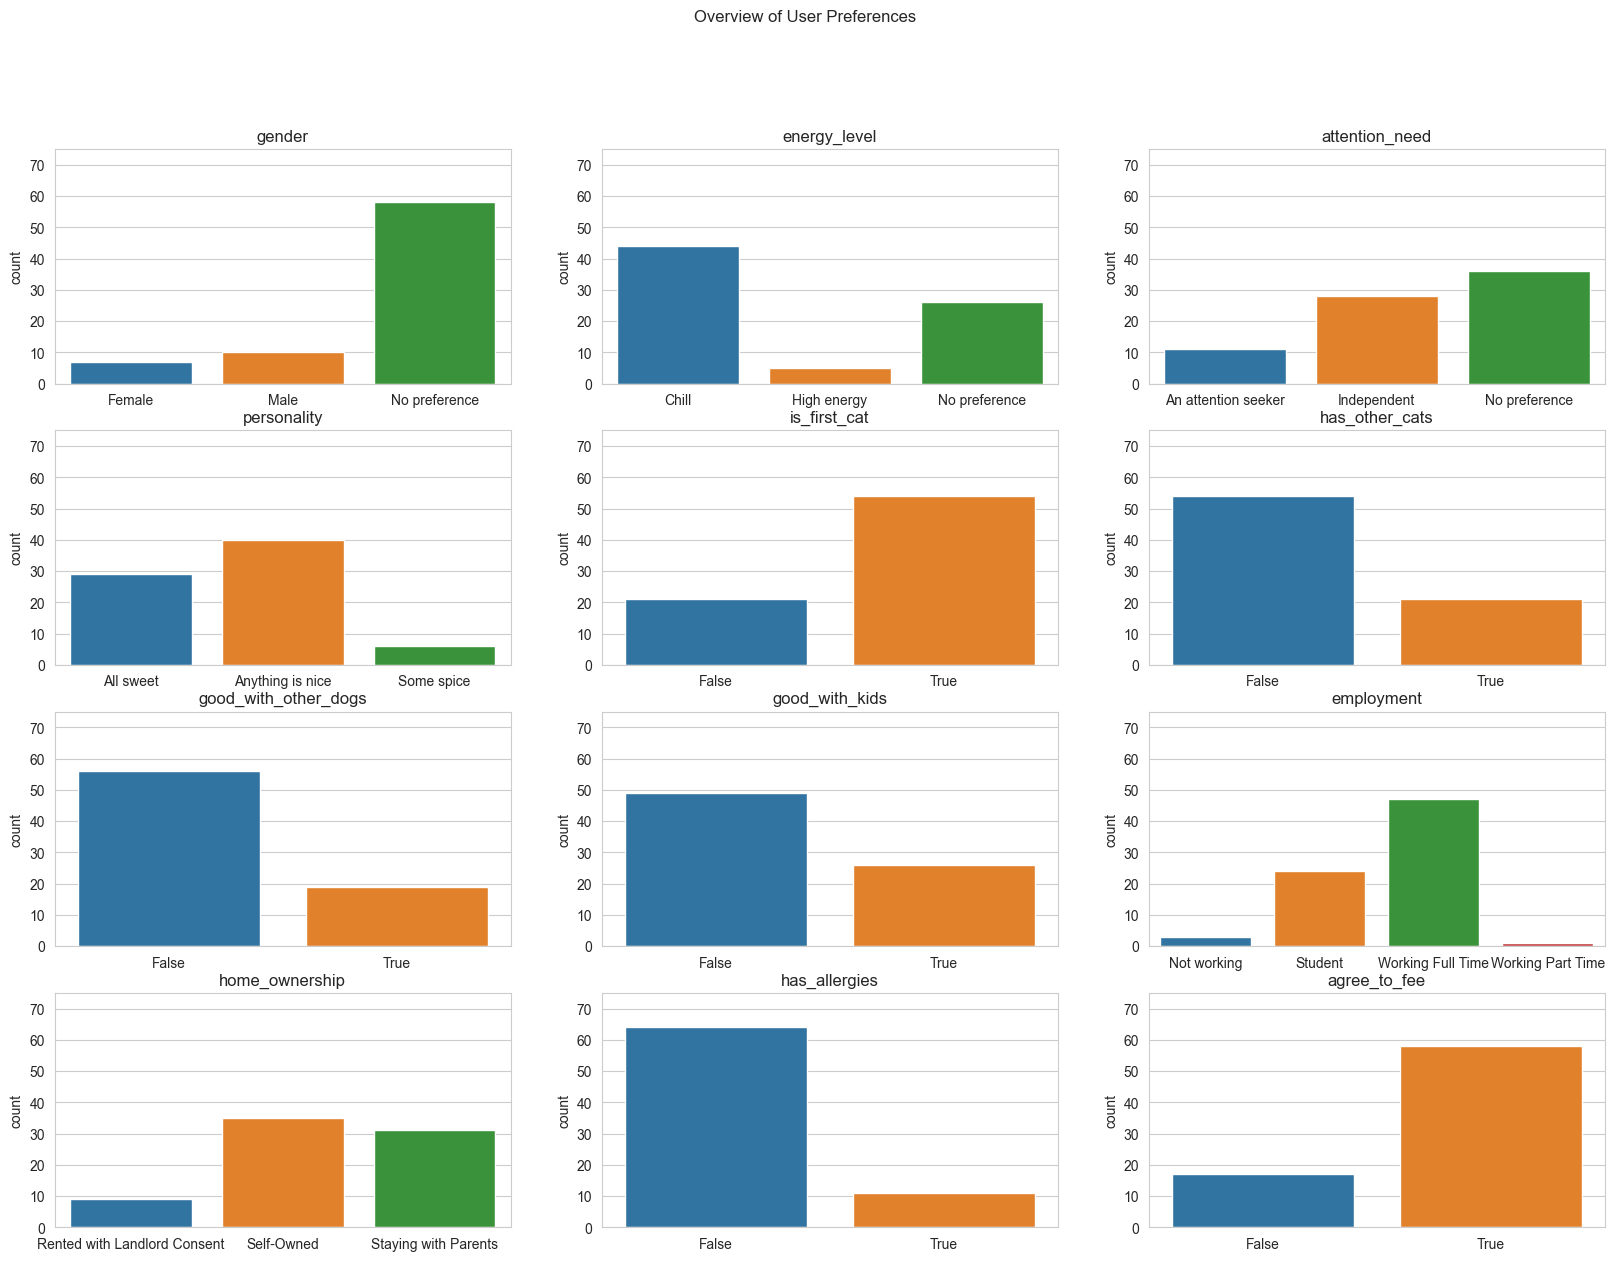

In [31]:
fig = plt.figure(figsize=(20, 14))
fig.tight_layout()
axes = fig.subplots(ncols=3, nrows=math.ceil(len(user_pref) / 3))

fig.suptitle('Overview of User Preferences')
for ax, pref in zip(axes.reshape(-1), user_pref):
    pt = sns.countplot(x=pref, data=cl_users, ax=ax)
    pt.set(ylim=(0, cl_users['id'].nunique()))
    pt.set(xlabel=None)
    ax.set_title(pref)

Text(0.5, 0.98, 'Distribution of Age Group Preference')

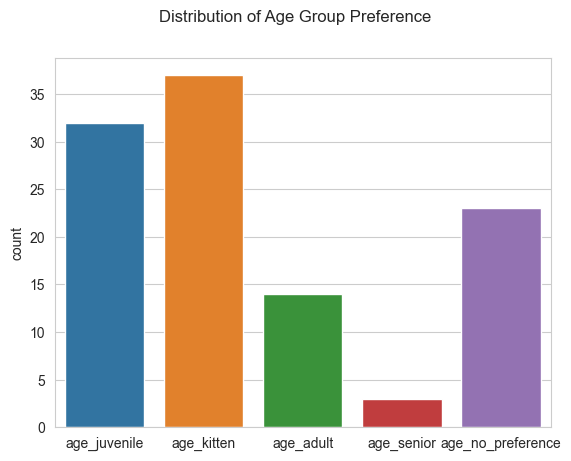

In [32]:
mask = cl_users.columns.str.startswith('age_')
age_columns = pd.melt(cl_users.loc[:,mask])

fig = plt.figure()
ax = fig.subplots(1,1)
pt = sns.countplot(data=age_columns[age_columns['value']==True], x='variable', ax=ax)
pt.set(xlabel=None)
fig.suptitle('Distribution of Age Group Preference')

Text(0.5, 0.98, 'Distribution of Primary Color Preference')

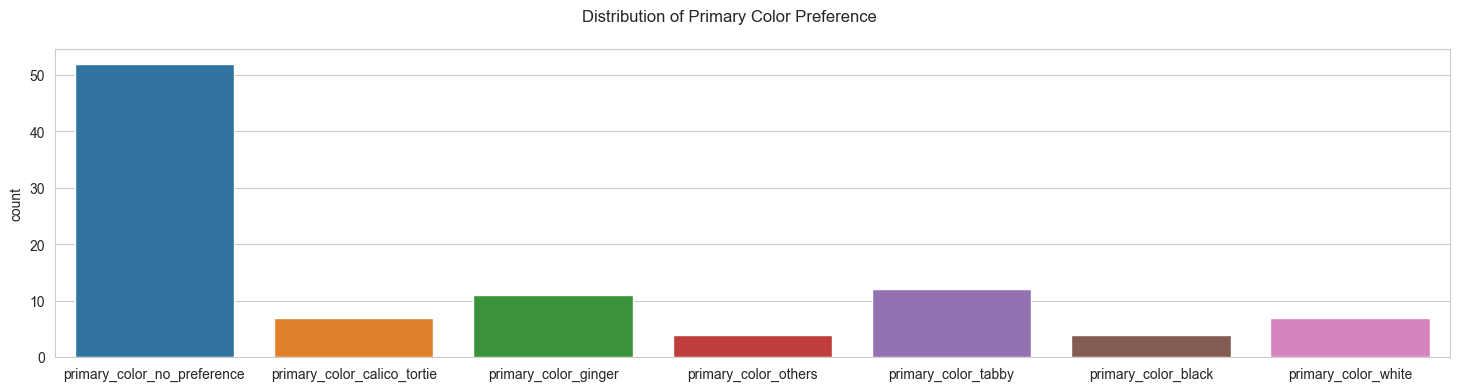

In [33]:
mask = cl_users.columns.str.startswith('primary_color_')
color_columns = pd.melt(cl_users.loc[:,mask])

fig = plt.figure(figsize=(18, 4))
ax = fig.subplots(1,1)
pt = sns.countplot(data=color_columns[color_columns['value']==True], x='variable',ax=ax)
pt.set(xlabel=None)
fig.suptitle('Distribution of Primary Color Preference')

### 3b. Cats

In [34]:
cats_desc = ['gender', 'breed',
       'primary_color', 'age_group',
       'energy_level', 'attention_need', 'personality',
       'good_first_cat', 'good_with_other_cats', 'good_with_other_dogs',
       'good_with_kids', 'preferred_employment', 'preferred_home_ownership',
       'good_with_allergies', 'require_fee']

cats_personality = ['playful', 'active',
       'curious', 'talkative', 'quiet', 'loving', 'sweet', 'likes_held',
       'friendly', 'shy', 'spicy', 'loves_attention']

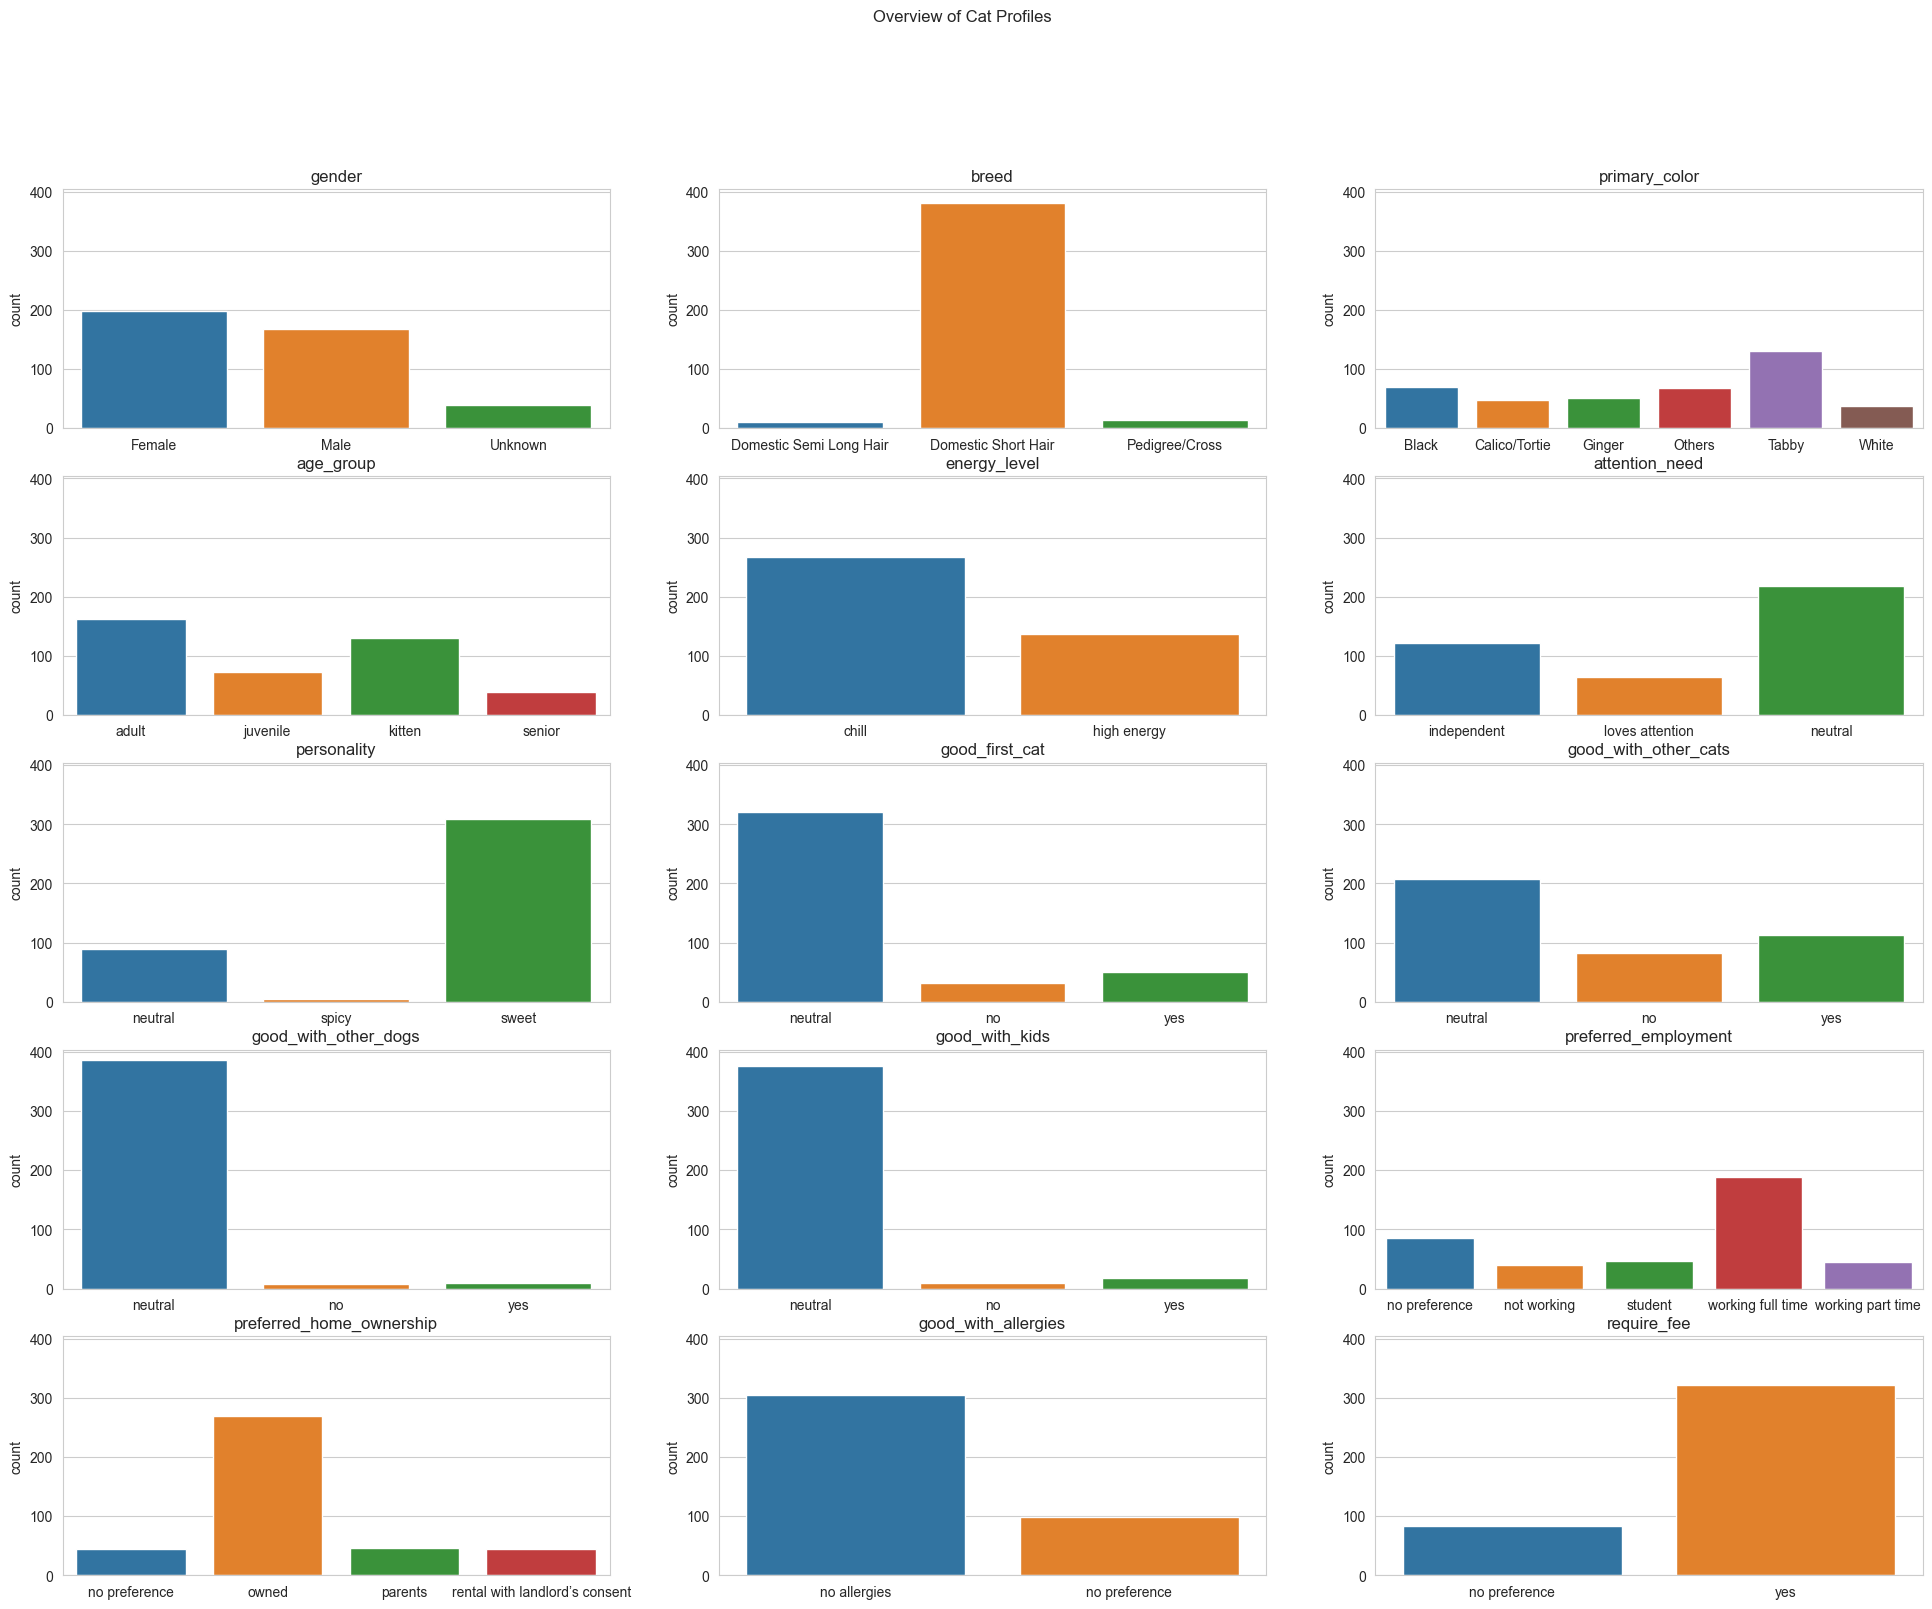

In [35]:
fig = plt.figure(figsize=(24, 18))
fig.tight_layout()
axes = fig.subplots(ncols=3, nrows=math.ceil(len(cats_desc) / 3))

fig.suptitle('Overview of Cat Profiles')
for ax, pref in zip(axes.reshape(-1), cats_desc):
    pt = sns.countplot(x=pref, data=cl_cats, ax=ax)
    pt.set(ylim=(0, cl_cats['id'].nunique()))
    pt.set(xlabel=None)
    ax.set_title(pref)

Text(0.5, 0.98, 'Distribution of Detailed Personality')

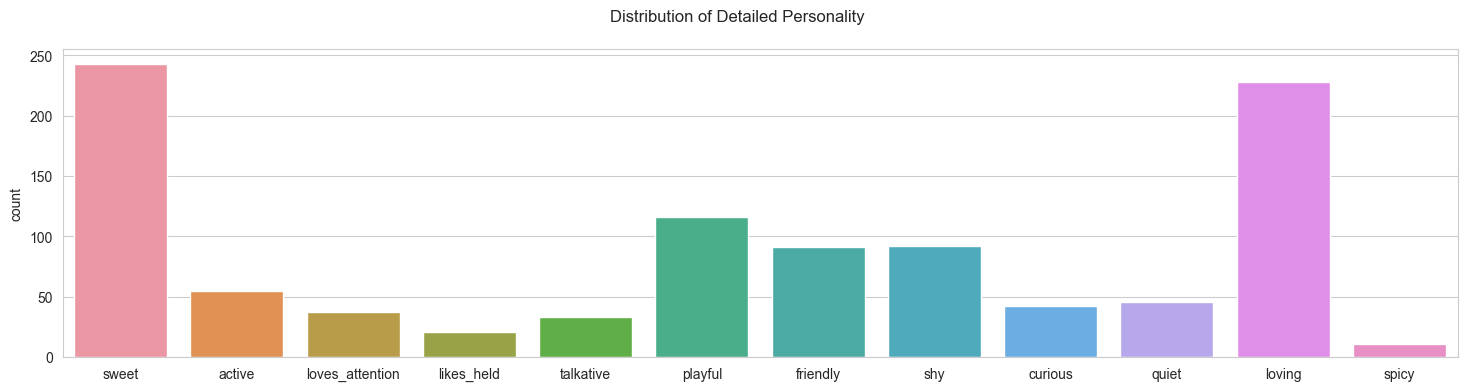

In [36]:
mask = cl_cats.columns.isin(cats_personality)
personality_columns = pd.melt(cl_cats.loc[:,mask])

fig = plt.figure(figsize=(18, 4))
ax = fig.subplots(1,1)
pt = sns.countplot(data=personality_columns[personality_columns['value']==True], x='variable',ax=ax)
pt.set(xlabel=None)
fig.suptitle('Distribution of Detailed Personality')

### 3c. User-Cat Interactions

In [37]:
cl_interactions.columns

Index(['id', '__typename', '_lastChangedAt', '_version', 'catID', 'userID',
       'updated_at', 'like', 'created_at', 'dwell_time_ms', 'click'],
      dtype='object')

In [38]:
cl_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              2958 non-null   object             
 1   __typename      2958 non-null   object             
 2   _lastChangedAt  2958 non-null   int64              
 3   _version        2958 non-null   int64              
 4   catID           2958 non-null   object             
 5   userID          2958 non-null   object             
 6   updated_at      2958 non-null   datetime64[ns, UTC]
 7   like            2958 non-null   bool               
 8   created_at      2958 non-null   datetime64[ns, UTC]
 9   dwell_time_ms   2958 non-null   int64              
 10  click           2958 non-null   bool               
dtypes: bool(2), datetime64[ns, UTC](2), int64(3), object(4)
memory usage: 213.9+ KB


In [39]:
print(f'# users with interactions: {cl_interactions["userID"].nunique()}')
print(f'# unique cats interacted with: {cl_interactions["catID"].nunique()}')

# users with interactions: 74
# unique cats interacted with: 100


#### i. Sparsity

In [40]:
def calc_sparsity(n_users, n_items, data, title):
    n_ratings = len(data)
    rating_matrix_size = n_users * n_items
    sparsity = 1 - n_ratings / rating_matrix_size

    print(f"Data Type: {title}")
    print("=" * 40)
    print(f"Number of users: {n_users}")
    print(f"Number of items: {n_items}")
    print(f"Number of available interactions: {n_ratings}")
    print(f"Number of all possible interactions: {rating_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.2f}%")
    print(" " * 40)

In [41]:
calc_sparsity(cl_users['id'].nunique(), cl_cats['id'].nunique(), cl_interactions, 'Likes')
calc_sparsity(cl_users['id'].nunique(), cl_cats['id'].nunique(), cl_interactions[cl_interactions['click'] == True], 'Expanded Profile')

Data Type: Likes
Number of users: 75
Number of items: 404
Number of available interactions: 2958
Number of all possible interactions: 30300
----------------------------------------
SPARSITY: 90.24%
                                        
Data Type: Expanded Profile
Number of users: 75
Number of items: 404
Number of available interactions: 1128
Number of all possible interactions: 30300
----------------------------------------
SPARSITY: 96.28%
                                        


#### ii. User-Cat Interactions Distribution

Text(0.5, 0.98, 'Likes')

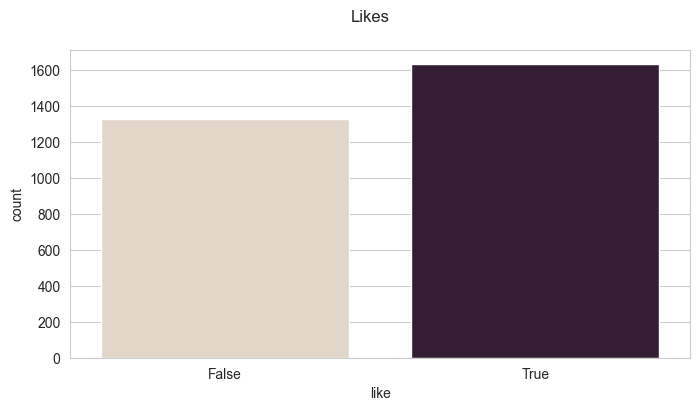

In [42]:
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1)

sns.countplot(x="like", data=cl_interactions, palette="ch:.25", ax=axes)
fig.suptitle('Likes', fontsize='large')

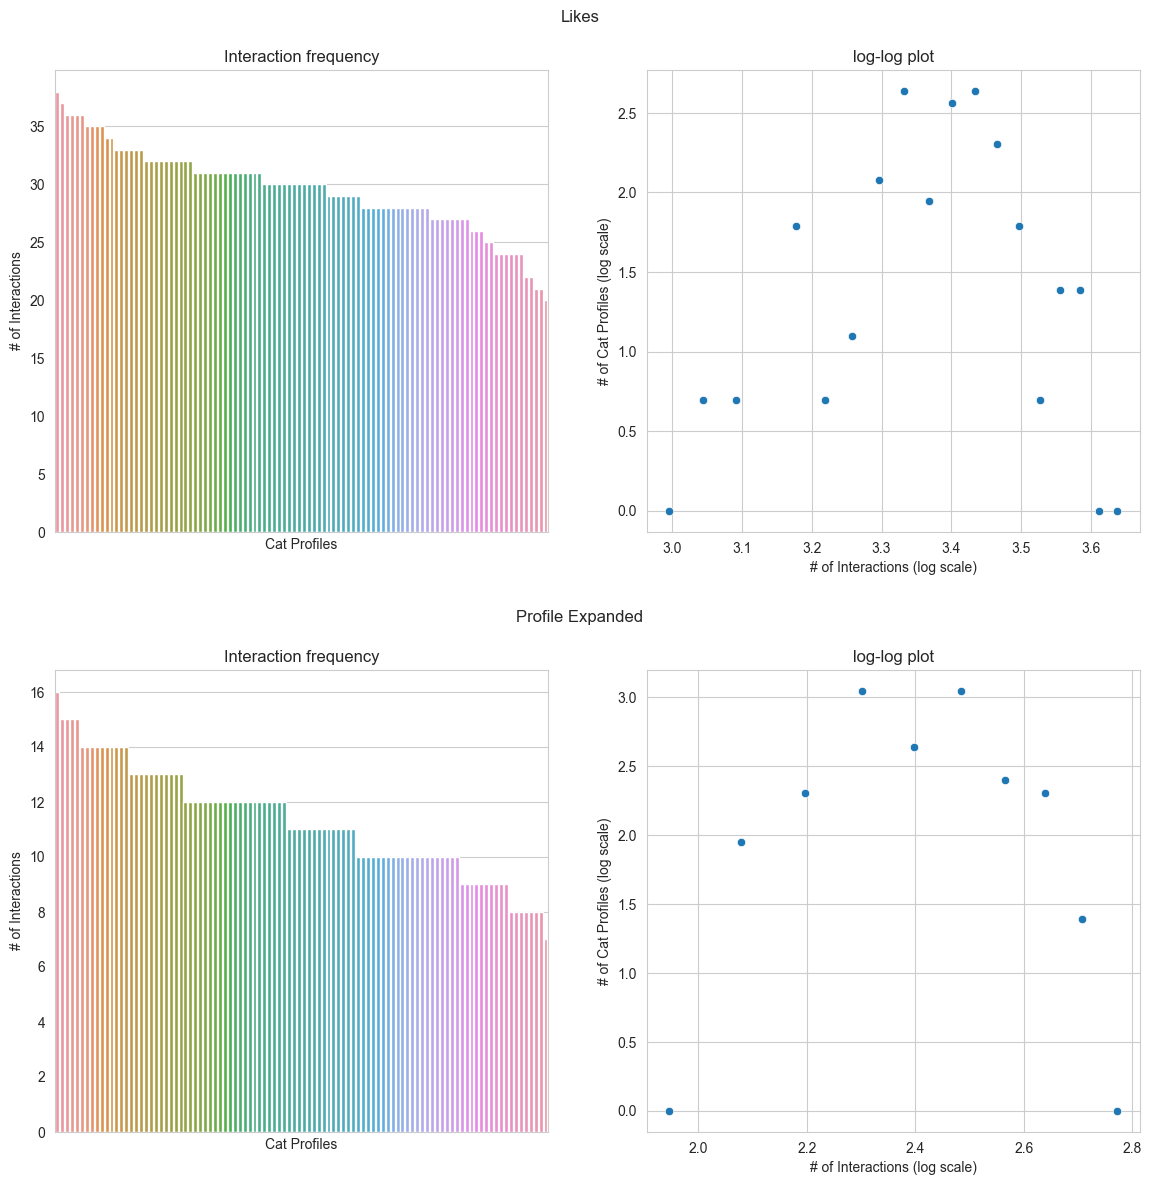

In [43]:
fig = plt.figure(figsize=(14, 12))
subfig = fig.subfigures(nrows=2, ncols=1)

def plotFrequency(subfig, data, title):
    axes = subfig.subplots(nrows=1, ncols=2)
    subfig.suptitle(title, fontsize='large')

    sns.countplot(data=data, x="catID", order = data["catID"].value_counts().index, ax=axes[0])
    axes[0].set_xticks([])
    axes[0].set(title="Interaction frequency",
                xlabel="Cat Profiles",
                ylabel="# of Interactions")

    count = data.groupby("catID")["userID"].nunique().sort_values(ascending=False)
    count = count.value_counts()
    sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
    axes[1].set(title="log-log plot", xlabel="# of Interactions (log scale)", ylabel="# of Cat Profiles (log scale)")

plotFrequency(subfig[0], cl_interactions, 'Likes')
plotFrequency(subfig[1], cl_interactions[cl_interactions['click'] == True], 'Profile Expanded')
# plotFrequency(subfig[2], data, 'Dwell Time')

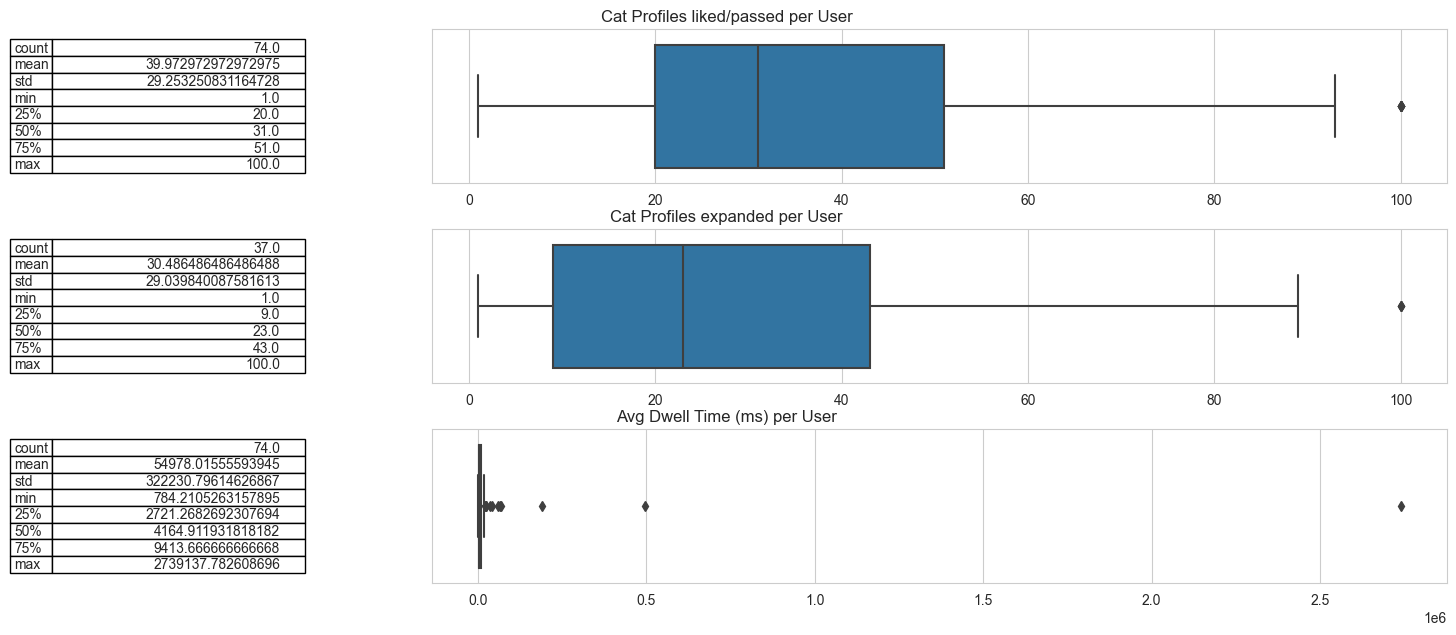

In [44]:
fig = plt.figure(figsize=(18, 6))
subfig = fig.subfigures(nrows=3, ncols=1)

def plot_rating_count(subfig, data, title):
    axes = subfig.subplots(nrows=1, ncols=2, width_ratios=[1, 4])

    desc = data.describe().astype(str)
    axes[0].axis('off')
    axes[0].axis('tight')
    axes[0].table(cellText=np.atleast_2d(desc.values).T, rowLabels=desc.index.tolist(), loc='center')

    sns.boxplot(x=data.values, ax=axes[1])
    subfig.suptitle(title, fontsize='large')

likes = cl_interactions.value_counts('userID')
plot_rating_count(subfig[0], likes, 'Cat Profiles liked/passed per User')

clicks = cl_interactions[cl_interactions['click'] == True].value_counts('userID')
plot_rating_count(subfig[1], clicks, 'Cat Profiles expanded per User')

dwell_time = cl_interactions.groupby('userID')['dwell_time_ms'].mean()
plot_rating_count(subfig[2], dwell_time, 'Avg Dwell Time (ms) per User')

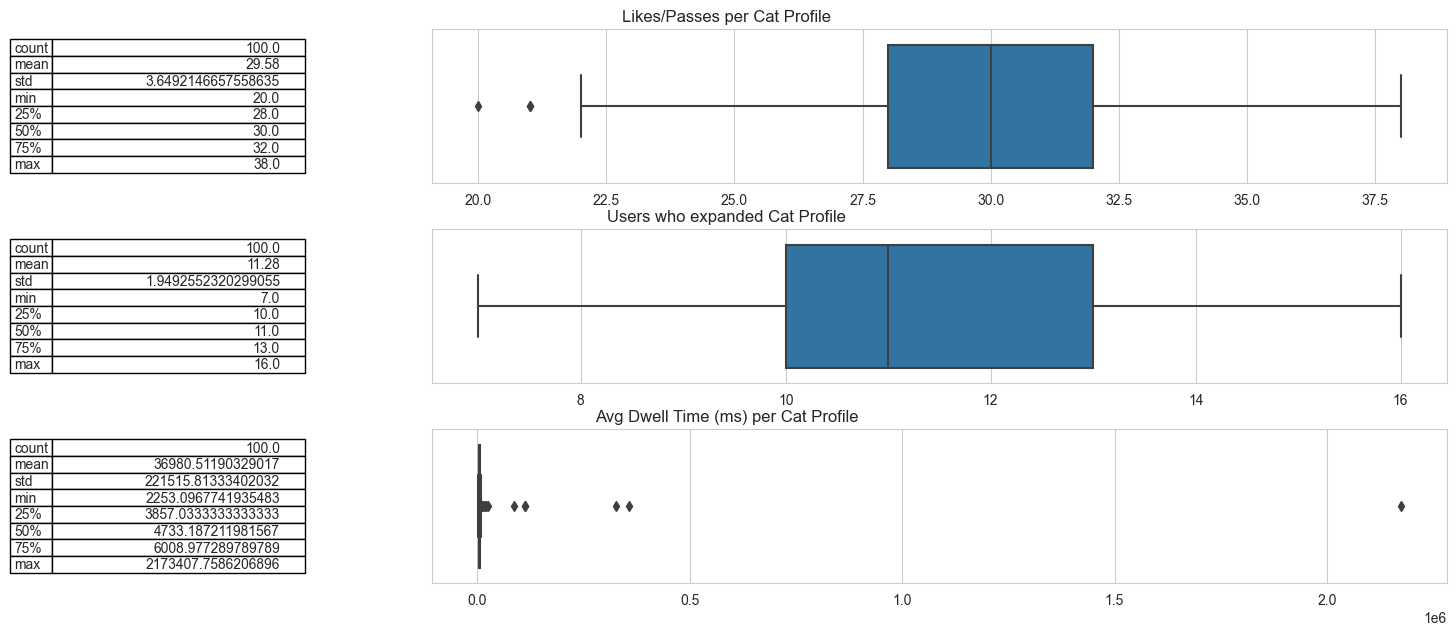

In [45]:
fig = plt.figure(figsize=(18, 6))
subfig = fig.subfigures(nrows=3, ncols=1)

likes = cl_interactions.value_counts('catID')
plot_rating_count(subfig[0], likes, 'Likes/Passes per Cat Profile')

clicks = cl_interactions[cl_interactions['click'] == True].value_counts('catID')
plot_rating_count(subfig[1], clicks, 'Users who expanded Cat Profile')

dwell_time = cl_interactions.groupby('catID')['dwell_time_ms'].mean()
plot_rating_count(subfig[2], dwell_time, 'Avg Dwell Time (ms) per Cat Profile')